# 降维算法1-PCA

## 1 概述

### 1.1从什么叫“维度”说开来

我们已经带大家认识了两个算法和数据预处理过程。期间，我们不断提到一些语言，比如说：随机森林是通过随机抽取特征来建树，以避免高维计算；再比如说，sklearn中导入特征矩阵，必须是至少二维；上周我们讲解特征工程，还特地提到了，特征选择的目的是通过降维来降低算法的计算成本……这些语言都很正常地被我用来使用，直到有一天，一个小伙伴问了我，”维度“到底是什么？

对于数组和Series来说，**维度就是功能shape返回的结果，shape中返回了几个数字，就是几维。** 索引以外的数据，不分行列的叫一维（此时shape返回唯一的维度上的数据个数），有行列之分叫二维（shape返回行x列），也称为表。一张表最多二维，复数的表构成了更高的维度。当一个数组中存在2张3行4列的表时，shape返回的是(更高维，行，列)。当数组中存在2组2张3行4列的表时，数据就是4维，shape返回(2,2,3,4)。

![image.png](https://pic3.zhimg.com/80/v2-a4eb5d500bb6fc65cfe0e6d7d18a8872_720w.jpg)

数组中的每一张表，都可以是一个**特征矩阵** 或一个DataFrame，这些结构永远只有一张表，所以一定有行列，其中行是样本，列是特征。针对每一张表，**维度指的是样本的数量或特征的数量，一般无特别说明，指的都是特征的数量。** 除了索引之外，一个特征是一维，两个特征是二维，n个特征是n维。

![image.png](https://pic3.zhimg.com/80/v2-ccfeceb798601a5e88eb2bf30f9bb72e_720w.png)

**对图像来说，维度就是图像中特征向量的数量。** 特征向量可以理解为是坐标轴，一个特征向量定义一条直线，是一维，两个相互垂直的特征向量定义一个平面，即一个直角坐标系，就是二维，三个相互垂直的特征向量定义一个空间，即一个立体直角坐标系，就是三维。三个以上的特征向量相互垂直，定义人眼无法看见，也无法想象的高维空间。

![image.png](https://pic2.zhimg.com/80/v2-77c07877291259decbf322e059b06ba9_720w.jpg)

**降维算法中的”降维“，指的是降低特征矩阵中特征的数量。** 上周的课中我们说过，降维的目的是为了让**算法运算更快，效果更好**，但其实还有另一种需求：**数据可视化**。从上面的图我们其实可以看得出，图像和特征矩阵的维度是可以相互对应的，即一个特征对应一个特征向量，对应一条坐标轴。所以，三维及以下的特征矩阵，是可以被可视化的，这可以帮助我们很快地理解数据的分布，而三维以上特征矩阵的则不能被可视化，数据的性质也就比较难理解。

### 1.2 sklearn中的降维算法

sklearn中降维算法都被包括在模块decomposition中，这个模块本质是一个矩阵分解模块。在过去的十年中，如果要讨论算法进步的先锋，矩阵分解可以说是独树一帜。矩阵分解可以用在降维，深度学习，聚类分析，数据预处理，低纬度特征学习，推荐系统，大数据分析等领域。在2006年，Netflix曾经举办了一个奖金为100万美元的推荐系统算法比赛，最后的获奖者就使用了矩阵分解中的明星：奇异值分解SVD。(～o￣3￣)～菊安酱会讲SVD在推荐系统中的应用，大家不要错过！

![image.png](https://pic1.zhimg.com/80/v2-a86e97beb55eaefceaa071942830bc64_720w.jpg)

SVD和主成分分析PCA都属于矩阵分解算法中的入门算法，都是通过分解特征矩阵来进行降维，它们也是我们今天要讲解的重点。虽然是入门算法，却不代表PCA和SVD简单：下面两张图是我在一篇SVD的论文中随意截取的两页，可以看到满满的数学公式（基本是线性代数）。要想在短短的一个小时内，给大家讲明白这些公式，我讲完不吐血大家听完也吐血了。所以今天，我会用最简单的方式为大家呈现降维算法的原理，但这注定意味着大家无法看到这个算法的全貌，**在机器学习中逃避数学是邪道**，所以更多原理大家自己去阅读。

## 2 PCA与SVD

在降维过程中，我们会减少特征的数量，这意味着删除数据，数据量变少则表示模型可以获取的信息会变少，模型的表现可能会因此受影响。同时，在高维数据中，必然有一些特征是不带有有效的信息的（比如噪音），或者有一些特征带有的信息和其他一些特征是重复的（比如一些特征可能会线性相关）。我们希望能够找出一种办法来帮助我们衡量特征上所带的信息量，让我们在降维的过程中，能够**即减少特征的数量，又保留大部分有效信息**——将那些带有重复信息的特征合并，并删除那些带无效信息的特征等等——逐渐创造出能够代表原特征矩阵大部分信息的，特征更少的，新特征矩阵。<br>
<br>
上周的特征工程课中，我们提到过一种重要的特征选择方法：方差过滤。如果一个特征的方差很小，则意味着这个特征上很可能有大量取值都相同（比如90%都是1，只有10%是0，甚至100%是1），那这一个特征的取值对样本而言就没有区分度，这种特征就不带有有效信息。从方差的这种应用就可以推断出，如果一个特征的方差很大，则说明这个特征上带有大量的信息。因此，**在降维中，PCA使用的信息量衡量指标，就是样本方差，又称可解释性方差，方差越大，特征所带的信息量越多。**

![image.png](https://www.zhihu.com/equation?tex=Var+%3D+%5Cfrac%7B1%7D%7Bn-1%7D%5Csum_%7Bi%3D1%7D%5E%7Bn%7D%28x_i+-+%5Chat%7Bx%7D%29%5E2%5C%5C)

Var代表一个特征的方差，n代表样本量，![image.png](https://www.zhihu.com/equation?tex=x_i)代表一个特征中的每个样本取值，![image-2.png](https://www.zhihu.com/equation?tex=%5Chat+x)代表这一列样本的均值。

面试高危问题：<br>
方差计算公式中为什么除数是n-1?<br>
这是为了得到样本方差的无偏估计，更多大家可以自己去探索~

### 2.1 降维究竟是怎样实现？

class sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False, svd_solver=’auto’, tol=0.0, iterated_power=’auto’, random_state=None)

PCA作为矩阵分解算法的核心算法，其实没有太多参数，但不幸的是每个参数的意义和运用都很难，因为几乎每个参数都涉及到高深的数学原理。为了参数的运用和意义变得明朗，我们来看一组简单的二维数据的降维。

![image.png](https://pic1.zhimg.com/80/v2-ccd755ce0fedb51bf8200846c832276c_720w.jpg)

我们现在有一组简单的数据，有特征x1和x2，三个样本数据的坐标点分别为(1,1)，(2,2)，(3,3)。我们可以让x1和x2分别作为两个特征向量，很轻松地用一个二维平面来描述这组数据。这组数据现在每个特征的均值都为2，方差则等于：

![image.png](https://www.zhihu.com/equation?tex=x1%5C_var+%3D+x2%5C_var+%3D+%5Cfrac%7B%281-2%29%5E2+%2B+%282-2%29%5E2+%2B+%283-2%29%5E2%7D%7B2%7D+%3D+1%5C%5C)

每个特征的数据一模一样，因此方差也都为1，数据的方差总和是2。<br>
<br>
现在我们的目标是：只用一个特征向量来描述这组数据，即将二维数据降为一维数据，并且尽可能地保留信息量，即让数据的总方差尽量靠近2。于是，我们将原本的直角坐标系逆时针旋转45°，形成了新的特征向量x1\*和x2\*组成的新平面，在这个新平面中，三个样本数据的坐标点可以表示为，，。可以注意到，x2\*上的数值此时都变成了0，因此x2\*明显不带有任何有效信息了（此时x2\*的方差也为0了）。此时，x1\*特征上的数据均值是，而方差则可表示成：

![image.png](https://www.zhihu.com/equation?tex=x2%5E%2A%5C_var+%3D+%5Cfrac%7B%28%5Csqrt%7B2%7D+-+2%5Csqrt%7B2%7D%29%5E2%2B%282%5Csqrt%7B2%7D+-+2%5Csqrt%7B2%7D%29%5E2%2B%283%5Csqrt%7B2%7D+-+2%5Csqrt%7B2%7D%29%5E2%7D%7B2%7D+%3D+2%5C%5C)

x1\*上的数据均值为0，方差也为0。<br>
<br>
此时，我们根据信息含量的排序，取信息含量最大的一个特征，因为我们想要的是一维数据。所以我们可以将x2\*删除，同时也删除图中的x2\*特征向量，剩下的x1\*就代表了曾经需要两个特征来代表的三个样本点。通过旋转原有特征向量组成的坐标轴来找到新特征向量和新坐标平面，我们将三个样本点的信息压缩到了一条直线上，实现了二维变一维，并且尽量保留原始数据的信息。一个成功的降维，就实现了。

![image.png](https://pic1.zhimg.com/80/v2-ccd755ce0fedb51bf8200846c832276c_720w.jpg)

不难注意到，在这个降维过程中，有几个重要的步骤：

![image.png](https://pic3.zhimg.com/80/v2-c2d9495001dce9f721160d3577e293c6_720w.jpg)

在步骤3当中，我们用来**找出n个新特征向量，让数据能够被压缩到少数特征上并且总信息量不损失太多的技术就是矩阵分解。** PCA和SVD是两种不同的降维算法，但他们都遵从上面的过程来实现降维，只是两种算法中矩阵分解的方法不同，信息量的衡量指标不同罢了。PCA使用方差作为信息量的衡量指标，并且特征值分解来找出空间V。降维时，它会通过一系列数学的神秘操作（比如说，产生协方差矩阵）将特征矩阵X分解为以下三个矩阵，其中和是辅助的矩阵，Σ是一个对角矩阵（即除了对角线上有值，其他位置都是0的矩阵），其对角线上的元素就是方差。降维完成之后，PCA找到的每个新特征向量就叫做“主成分”，而被丢弃的特征向量被认为信息量很少，这些信息很可能就是噪音。

![image.png](https://www.zhihu.com/equation?tex=X+%E2%86%92%E6%95%B0%E5%AD%A6%E7%A5%9E%E7%A7%98%E7%9A%84%E5%AE%87%E5%AE%99%E2%86%92+Q%5CSigma+Q%5E%7B-1%7D%5C%5C)

而SVD使用奇异值分解来找出空间V，其中Σ也是一个对角矩阵，不过它对角线上的元素是奇异值，这也是SVD中用来衡量特征上的信息量的指标。U和V^{T}分别是左奇异矩阵和右奇异矩阵，也都是辅助矩阵。

![image.png](https://www.zhihu.com/equation?tex=X+%E2%86%92%E5%8F%A6%E4%B8%80%E4%B8%AA%E6%95%B0%E5%AD%A6%E7%A5%9E%E7%A7%98%E7%9A%84%E5%AE%87%E5%AE%99%E2%86%92+U%5CSigma+V%5E%7BT%7D%5C%5C)

在数学原理中，无论是PCA和SVD都需要遍历所有的特征和样本来计算信息量指标。并且在矩阵分解的过程之中，会产生比原来的特征矩阵更大的矩阵，比如原数据的结构是(m,n)，在矩阵分解中为了找出最佳新特征空间V，可能需要产生(n,n)，(m,m)大小的矩阵，还需要产生协方差矩阵去计算更多的信息。而现在无论是Python还是R，或者其他的任何语言，在大型矩阵运算上都不是特别擅长，无论代码如何简化，我们不可避免地要等待计算机去完成这个非常庞大的数学计算过程。因此，降维算法的计算量很大，运行比较缓慢，但无论如何，它们的功能无可替代，它们依然是机器学习领域的宠儿。

**思考：PCA和特征选择技术都是特征工程的一部分，它们有什么不同？**<br>
<br>
特征工程中有三种方式：特征提取，特征创造和特征选择。仔细观察上面的降维例子和上周我们讲解过的特征选择，你发现有什么不同了吗?<br>
特征选择是从已存在的特征中选取携带信息最多的，选完之后的特征依然具有可解释性，我们依然知道这个特征在原数据的哪个位置，代表着原数据上的什么含义。<br>
而PCA，是将已存在的特征进行压缩，降维完毕后的特征不是原本的特征矩阵中的任何一个特征，而是通过某些方式组合起来的新特征。通常来说，**在新的特征矩阵生成之前，我们无法知晓PCA都建立了怎样的新特征向量，新特征矩阵生成之后也不具有可读性，** 我们无法判断新特征矩阵的特征是从原数据中的什么特征组合而来，新特征虽然带有原始数据的信息，却已经不是原数据上代表着的含义了。以PCA为代表的降维算法因此是特征创造（feature creation，或feature construction）的一种。<br>
可以想见，PCA一般不适用于探索特征和标签之间的关系的模型（如线性回归），因为无法解释的新特征和标签之间的关系不具有意义。在线性回归模型中，我们使用特征选择。

### 2.2 重要参数n_components

n_components是我们降维后需要的维度，即降维后需要保留的特征数量，降维流程中第二步里需要确认的k值，一般输入[0, min(X.shape)]范围中的整数。一说到K，大家可能都会想到，类似于KNN中的K和随机森林中的n_estimators，这是一个需要我们人为去确认的超参数，并且我们设定的数字会影响到模型的表现。如果留下的特征太多，就达不到降维的效果，如果留下的特征太少，那新特征向量可能无法容纳原始数据集中的大部分信息，因此，n_components既不能太大也不能太小。那怎么办呢？<br>
<br>
可以先从我们的降维目标说起：如果我们希望可视化一组数据来观察数据分布，我们往往将数据降到三维以下，很多时候是二维，即n_components的取值为2。

#### 2.2.1 迷你案例：高维数据的可视化

**1 调用库和模块**

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

**2 提取数据集**

In [2]:
iris = load_iris()

In [3]:
X = iris.data

In [7]:
#作为数组，X是几维？
X.shape

(150, 4)

In [9]:
#作为数据表或特征矩阵，X是几维？
import pandas as pd
pd.DataFrame(X)

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [5]:
y = iris.target

In [6]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

**3 建模**

In [10]:
#调用PCA
pca = PCA(n_components=2)           #实例化   降到2维
pca = pca.fit(X)                    #拟合模型
X_dr = pca.transform(X)             #获取新矩阵

#也可以fit_transform一步到位
#X_dr = PCA(2).fit_transform(X)

In [12]:
X_dr.shape

(150, 2)

**4 可视化**

In [13]:
#要将三种鸢尾花的数据分布显示在二维平面坐标系中，
#对应的两个坐标（两个特征向量）应该是三种鸢尾花降维后的x1和x2，
#怎样才能取出三种鸢尾花下不同的x1和x2呢？

X_dr[y == 0, 0] #这里是布尔索引，看出来了么？

#要展示三中分类的分布，需要对三种鸢尾花分别绘图
#可以写成三行代码，也可以写成for循环

array([-2.68412563, -2.71414169, -2.88899057, -2.74534286, -2.72871654,
       -2.28085963, -2.82053775, -2.62614497, -2.88638273, -2.6727558 ,
       -2.50694709, -2.61275523, -2.78610927, -3.22380374, -2.64475039,
       -2.38603903, -2.62352788, -2.64829671, -2.19982032, -2.5879864 ,
       -2.31025622, -2.54370523, -3.21593942, -2.30273318, -2.35575405,
       -2.50666891, -2.46882007, -2.56231991, -2.63953472, -2.63198939,
       -2.58739848, -2.4099325 , -2.64886233, -2.59873675, -2.63692688,
       -2.86624165, -2.62523805, -2.80068412, -2.98050204, -2.59000631,
       -2.77010243, -2.84936871, -2.99740655, -2.40561449, -2.20948924,
       -2.71445143, -2.53814826, -2.83946217, -2.54308575, -2.70335978])

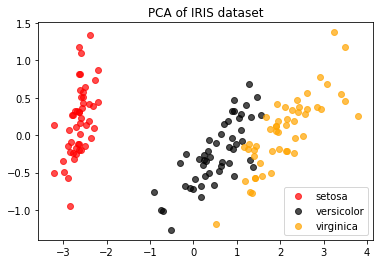

In [14]:
"""
plt.figure()
plt.scatter(X_dr[y==0, 0], X_dr[y==0, 1], c="red", label=iris.target_names[0])
plt.scatter(X_dr[y==1, 0], X_dr[y==1, 1], c="black", label=iris.target_names[1])
plt.scatter(X_dr[y==2, 0], X_dr[y==2, 1], c="orange", label=iris.target_names[2])
plt.legend()
plt.title('PCA of IRIS dataset')
plt.show()
"""
colors = ['red', 'black', 'orange']
iris.target_names

plt.figure()
for i in [0, 1, 2]:
    plt.scatter(X_dr[y == i, 0]
                ,X_dr[y == i, 1]
                ,alpha=.7
                ,c=colors[i]
                ,label=iris.target_names[i]
               )
plt.legend()
plt.title('PCA of IRIS dataset')
plt.show()

鸢尾花的分布被展现在我们眼前了，明显这是一个分簇的分布，并且每个簇之间的分布相对比较明显，也许versicolor和virginia这两种花之间会有一些分类错误，但setosa肯定不会被分错。这样的数据很容易分类，可以遇见，KNN，随机森林，神经网络，朴素贝叶斯，Adaboost这些分类器在鸢尾花数据集上，未调整的时候都可以有95%上下的准确率。

**5 探索降维后的数据**